# EDA и базовые модели для прогноза спроса на молочную продукцию

В этом ноутбуке:

1. Загружаем и исследуем данные (EDA).
2. Строим несколько базовых моделей (Linear Regression, Random Forest).
3. Сравниваем их качество по метрикам R² и RMSE.
4. Сравниваем с нейросетевой моделью из основного пайплайна (опционально).

In [13]:
# Импорты для EDA и базовых моделей
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Чтобы можно было импортировать пакет dairy_demand из src/
sys.path.append(os.path.join("..", "src"))

from dairy_demand.config import (
    DATE_COLUMN,
    TARGET_COLUMN,
    FEATURES,
    CATEGORICAL,
    TEST_SIZE,
    RANDOM_STATE,
)
from dairy_demand.data import add_date_features, prepare_features_and_target, get_preprocessor

# Графики в нотаутике
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.1)

# Путь к данным (подстрой под себя, если нужно)
DATA_PATH = os.path.join("..", "data", "dairy_data.csv")

## Загрузка данных и быстрый обзор

In [14]:
df_raw = pd.read_csv(DATA_PATH)
df = add_date_features(df_raw)

df.head()

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg),Total Value,Price per Unit (sold),Approx. Total Revenue(INR),Production Date,Expiration Date,Month,Season
0,Kolkata,129.35,10,Small,2023-03-13,2,Paneer,Mother Dairy,442.81,33.55,...,401,66,149,14856.2755,32.655304,17470.587753,2023-03-09,2023-04-25,3,Spring
1,Bangalore,250.57,38,Large,2020-10-27,9,Butter,Amul,654.59,32.01,...,262,21,157,20953.4259,32.933634,16466.816815,2020-10-23,2020-12-17,10,Autumn
2,Chennai,764.84,60,Large,2020-07-18,4,Paneer,Nestle,270.67,76.11,...,198,62,73,20600.6937,75.351101,19289.881935,2020-07-16,2020-08-04,7,Summer
3,Bangalore,98.73,73,Large,2022-03-11,6,Curd,Amul,667.38,91.71,...,213,23,115,61205.4198,96.292053,71159.827391,2022-03-09,2022-04-25,3,Spring
4,Bangalore,517.91,13,Medium,2021-04-11,7,Cheese,LocalFarm,999.98,80.75,...,265,82,59,80748.3850,77.451778,14793.289594,2021-04-10,2021-04-17,4,Spring


In [15]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Location                             5000 non-null   str           
 1   Total Land Area (acres)              5000 non-null   float64       
 2   Number of Cows                       5000 non-null   int64         
 3   Farm Size                            5000 non-null   str           
 4   Date                                 5000 non-null   datetime64[us]
 5   Product ID                           5000 non-null   int64         
 6   Product Name                         5000 non-null   str           
 7   Brand                                5000 non-null   str           
 8   Quantity (liters/kg)                 5000 non-null   float64       
 9   Price per Unit                       5000 non-null   float64       
 10  Shelf Life (days)      

In [16]:
df.describe(include="all").T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Location,5000,5,Bangalore,1024,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Land Area (acres),5000.0,NaN,NaN,NaN,516.247216,50.03,281.285,510.995,746.6775,999.49,272.130012
Number of Cows,5000.0,NaN,NaN,NaN,63.9606,10.0,36.0,63.5,91.0,119.0,31.489277
Farm Size,5000,3,Medium,1681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,5000,NaN,NaN,NaN,2021-07-13 05:50:47.040000,2019-01-02 00:00:00,2020-04-23 00:00:00,2021-08-01 00:00:00,2022-10-15 06:00:00,2023-12-31 00:00:00,NaN
Product ID,5000.0,NaN,NaN,NaN,5.4488,1.0,3.0,5.0,8.0,10.0,2.823787
Product Name,5000,5,Paneer,1076,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brand,5000,4,Mother Dairy,1287,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity (liters/kg),5000.0,NaN,NaN,NaN,523.898198,50.1,292.0525,526.645,758.39,999.98,273.257583
Price per Unit,5000.0,NaN,NaN,NaN,54.540948,10.04,32.2275,54.415,76.88,99.99,25.869316


## Пропуски и базовые распределения

In [17]:
# Количество пропусков по столбцам
df.isna().sum().sort_values(ascending=False)

Location                               0
Total Land Area (acres)                0
Number of Cows                         0
Farm Size                              0
Date                                   0
Product ID                             0
Product Name                           0
Brand                                  0
Quantity (liters/kg)                   0
Price per Unit                         0
Shelf Life (days)                      0
Storage Condition                      0
Quantity Sold (liters/kg)              0
Customer Location                      0
Sales Channel                          0
Quantity in Stock (liters/kg)          0
Minimum Stock Threshold (liters/kg)    0
Reorder Quantity (liters/kg)           0
Total Value                            0
Price per Unit (sold)                  0
Approx. Total Revenue(INR)             0
Production Date                        0
Expiration Date                        0
Month                                  0
Season          

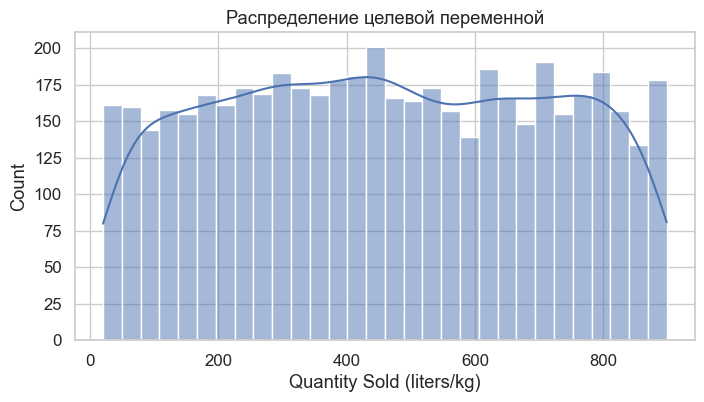

In [18]:
# Распределение целевой переменной
plt.figure(figsize=(8, 4))
sns.histplot(df[TARGET_COLUMN], kde=True, bins=30)
plt.title("Распределение целевой переменной")
plt.xlabel(TARGET_COLUMN)
plt.ylabel("Count")
plt.show()

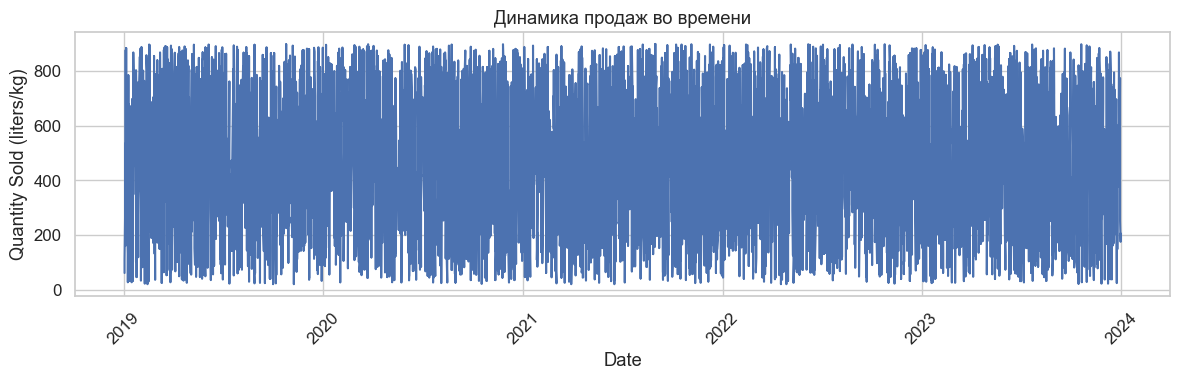

In [19]:
# Временной ряд по дате (если данные упорядочены по Date)
df_sorted = df.sort_values(DATE_COLUMN)

plt.figure(figsize=(12, 4))
plt.plot(df_sorted[DATE_COLUMN], df_sorted[TARGET_COLUMN])
plt.title("Динамика продаж во времени")
plt.xlabel("Date")
plt.ylabel(TARGET_COLUMN)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Сезонность и месячная динамика

Посмотрим, как меняется средний объём продаж по сезонам и месяцам.

In [20]:
# Средние продажи по сезонам
season_stats = df.groupby("Season")[TARGET_COLUMN].agg(["mean", "count"]).reset_index()
season_stats

,Season,mean,count
0,Autumn,448.114332,1242
1,Spring,469.893855,1253
2,Summer,457.946841,1298
3,Winter,465.956089,1207


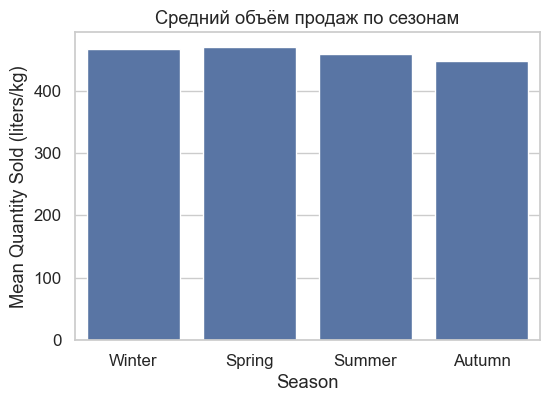

In [21]:
plt.figure(figsize=(6, 4))
sns.barplot(data=season_stats, x="Season", y="mean", order=["Winter", "Spring", "Summer", "Autumn"])
plt.title("Средний объём продаж по сезонам")
plt.xlabel("Season")
plt.ylabel(f"Mean {TARGET_COLUMN}")
plt.show()

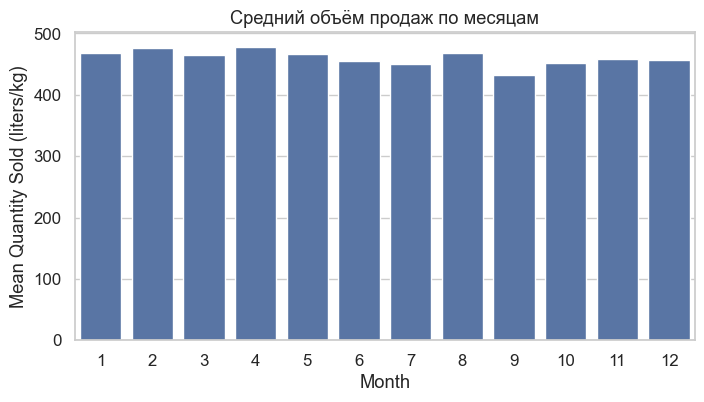

In [22]:
# Средние продажи по месяцам
month_stats = df.groupby("Month")[TARGET_COLUMN].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(data=month_stats, x="Month", y=TARGET_COLUMN)
plt.title("Средний объём продаж по месяцам")
plt.xlabel("Month")
plt.ylabel(f"Mean {TARGET_COLUMN}")
plt.show()

## Корреляции числовых признаков

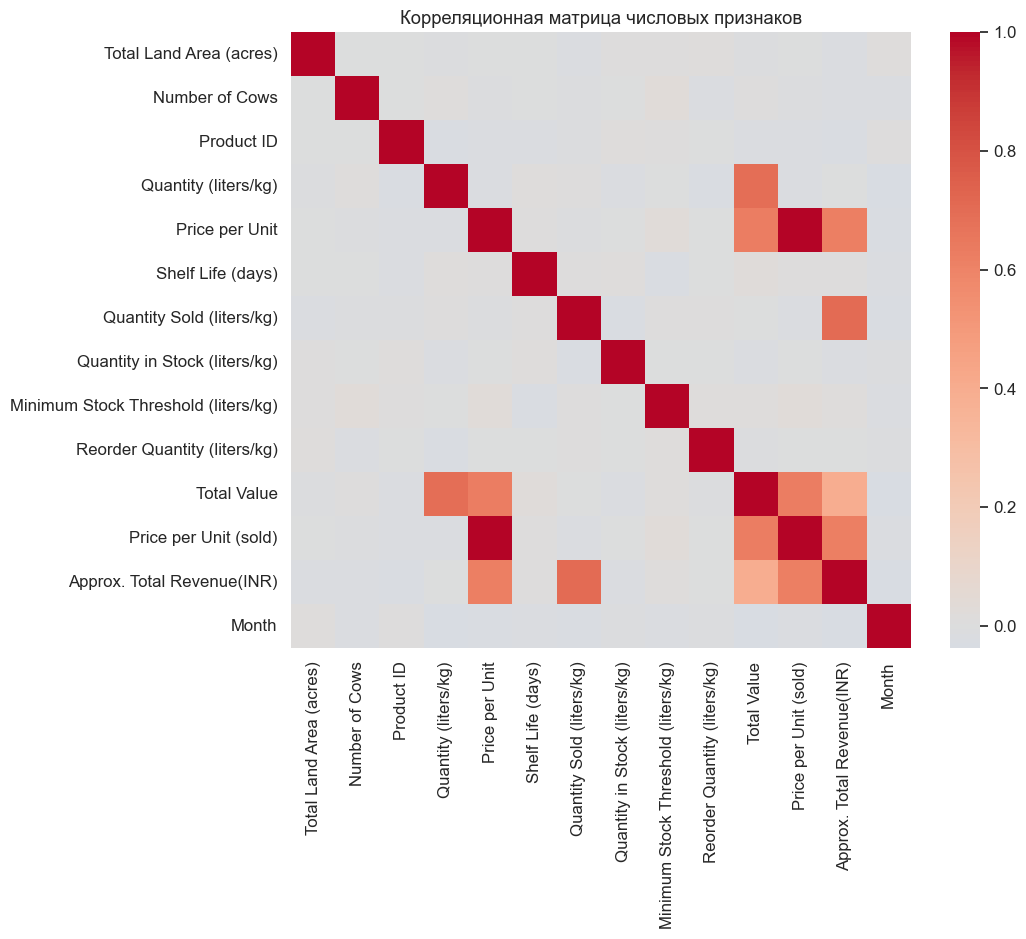

In [23]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Корреляционная матрица числовых признаков")
plt.show()

## Подготовка данных для базовых моделей

Будем использовать те же признаки, что и в основном проекте (`FEATURES`), и целевую колонку `TARGET_COLUMN`.
Препроцессинг (масштабирование числовых признаков + one-hot для категориальных) возьмём из функции `get_preprocessor()`.

In [24]:
X, y = prepare_features_and_target(df)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

preprocessor = get_preprocessor()

X_train.shape, X_test.shape

((4000, 16), (1000, 16))

In [ ]:
#  Вспомогательная функция для оценки моделей 
def print_regression_metrics(y_true, y_pred, model_name: str):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"=== {model_name} ===")
    print(f"R²  : {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print()
    return {"model": model_name, "r2": r2, "rmse": rmse, "mae": mae}

## Бэйзлайн 1: DummyRegressor (прогноз средним значением)

Это простейший ориентир: модель всегда предсказывает среднее по train.
Если наши модели не лучше этого, значит что-то не так.

In [26]:
dummy_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", DummyRegressor(strategy="mean")),
    ]
)

dummy_pipeline.fit(X_train, y_train)
y_pred_dummy = dummy_pipeline.predict(X_test)

metrics_dummy = print_regression_metrics(y_test, y_pred_dummy, "DummyRegressor (mean)")

=== DummyRegressor (mean) ===
R²  : -0.0001
RMSE: 250.0070
MAE : 215.4304



## Бэйзлайн 2: Линейная регрессия

Построим линейную модель на тех же признаках.

In [27]:
lr_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LinearRegression()),
    ]
)

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

metrics_lr = print_regression_metrics(y_test, y_pred_lr, "LinearRegression")

=== LinearRegression ===
R²  : 0.8274
RMSE: 103.8513
MAE : 76.5908



In [28]:
cv_scores_lr = cross_val_score(
    lr_pipeline,
    X,
    y,
    cv=5,
    scoring="r2",
    n_jobs=-1,
)

print("CV R² scores (LinearRegression):", cv_scores_lr)
print("Mean CV R²:", cv_scores_lr.mean())

CV R² scores (LinearRegression): [0.81612332 0.80954957 0.81484545 0.8145285  0.82433541]
Mean CV R²: 0.8158764499280993


## Сравнение моделей

In [29]:
results = pd.DataFrame(
    [metrics_dummy, metrics_lr]
).set_index("model")
results

,r2,rmse,mae
model,,,
DummyRegressor (mean),-0.000131,250.006984,215.430400
LinearRegression,0.827426,103.851258,76.590841
